# Reading Data From MongoDB

In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
client = MongoClient()
#point the client at mongo URI
client = MongoClient('mongodb://localhost:27017/')
#select database
db = client['Project']
#select the collection within the database
test = db.mldata
#convert entire collection to Pandas dataframe
test_ml = pd.DataFrame(list(test.find()))
print(test_ml)

                           _id  Age  DailyRate  DistanceFromHome  Education  \
0     624cfc96b2e85f37b5b5e119   41       1102                 1          2   
1     624cfc96b2e85f37b5b5e11a   49        279                 8          1   
2     624cfc96b2e85f37b5b5e11b   37       1373                 2          2   
3     624cfc96b2e85f37b5b5e11c   33       1392                 3          4   
4     624cfc96b2e85f37b5b5e11d   27        591                 2          1   
...                        ...  ...        ...               ...        ...   
2935  624cfc96b2e85f37b5b5ec90   36        884                23          2   
2936  624cfc96b2e85f37b5b5ec91   39        613                 6          1   
2937  624cfc96b2e85f37b5b5ec92   27        155                 4          3   
2938  624cfc96b2e85f37b5b5ec93   49       1023                 2          3   
2939  624cfc96b2e85f37b5b5ec94   34        628                 8          3   

      EnvironmentSatisfaction  HourlyRate  JobInvol

In [3]:
ml_df=test_ml.drop('_id', axis=1)

# Dependent and Independent Variables

In [4]:
y = ml_df["Attrition_Yes"]
X = ml_df.drop(["Attrition_Yes"],axis=1)

In [5]:
ml_df["Attrition_Yes"].value_counts()

0    2466
1     474
Name: Attrition_Yes, dtype: int64

In [6]:
print('No Attrition :', round(ml_df["Attrition_Yes"].value_counts()[0]/len(ml_df) * 100,2), '% of the dataset')
print('Attrition :', round(ml_df["Attrition_Yes"].value_counts()[1]/len(ml_df) * 100,2), '% of the dataset')

No Attrition : 83.88 % of the dataset
Attrition : 16.12 % of the dataset


# Smote for imbalanced dataset

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.15, 
                                                    random_state=2021,
                                                    stratify=y)
from imblearn.over_sampling import SMOTE
oversampled = SMOTE()
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [8]:
y_train_smote.value_counts()

0    2096
1    2096
Name: Attrition_Yes, dtype: int64

# 1. Naive Bayes
# i. MultinomialNB 

In [9]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


model =MultinomialNB()
params_NB = {'alpha': [0.00001,0.01, 0.1, 0.5, 1.0, 10.0 ]}
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
MNBgrid = GridSearchCV(estimator=model,  
                 param_grid=params_NB,
                 cv=kfold,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
MNBgrid.fit(X_train_smote, y_train_smote)

print(MNBgrid.best_params_)
print("Training score :",MNBgrid.best_score_)
y_pred = MNBgrid.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  MNBgrid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'alpha': 1e-05}
Training score : 0.5663254072782407
Test score : 0.5215419501133787
ROC_AUC_score 0.5669014084507042


# ii. GaussianNB 

In [13]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


model =GaussianNB()
params_NB = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
NBgrid = GridSearchCV(estimator=model,  
                 param_grid=params_NB,
                 cv=kfold,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
NBgrid.fit(X_train_smote, y_train_smote)

print(NBgrid.best_params_)
print("Training score :",NBgrid.best_score_)
y_pred = NBgrid.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  NBgrid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'var_smoothing': 1e-10}
Training score : 0.7562045394420565
Test score : 0.63718820861678
ROC_AUC_score 0.6585839360487248


# 2. DecisionTreeClassifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=2021)

kfold = StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)

parameters = {'max_depth':[x for x in range(10,20)],
              'min_samples_split':[x for x in range(10,16)],
              'min_samples_leaf':[x for x in range(8,16)]}

DTRcv = GridSearchCV(estimator=dtc, param_grid=parameters,
                  scoring='accuracy',cv=kfold,verbose=3)


DTRcv.fit(X_train_smote, y_train_smote)

print(DTRcv.best_params_)

print("Training score :",DTRcv.best_score_)
y_pred = DTRcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  DTRcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV 1/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.861 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.847 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.868 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.871 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=8, min_samples_split=10;, score=0.889 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.861 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.847 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.868 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=8, min_samples_split=11;, score=0.871 total time=   0.0s
[CV 5/5] END max_depth=10, 

# 3. LogisticRegression

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)
parameters={'solver':['newton-cg','liblinear','lbfgs','sag','saga'],
            'penalty':['l1','l2','elasticnet','none'],
            'l1_ratio':[0.1,0.5,0.8]}

LRcv = GridSearchCV(estimator=model, param_grid=parameters,cv=kfold,scoring='accuracy')

LRcv.fit(X_train_smote, y_train_smote)

print(LRcv.best_params_)
print("Training score :",LRcv.best_score_)
y_pred = LRcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  LRcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

{'l1_ratio': 0.1, 'penalty': 'none', 'solver': 'newton-cg'}
Training score : 0.8957563982579557
Test score : 0.8571428571428571
ROC_AUC_score 0.7156832889227256


# 4 Discriminant Analysis

# i. Quadratic Discriminant Analysis

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)

qda = QuadraticDiscriminantAnalysis()

QdaRes= cross_val_score(estimator=qda,X=X_train_smote,y=y_train_smote ,scoring='accuracy',cv=kfold)
QdaRoc= cross_val_score(estimator=qda,X=X_train_smote,y=y_train_smote ,scoring='roc_auc',cv=kfold)

print(QdaRes)
print("Accuracy_Score",QdaRes.mean())

print(QdaRoc)
print("Roc_Auc_Score",QdaRoc.mean())

[0.8057211  0.82359952 0.82696897 0.8221957  0.83412888]
Accuracy_Score 0.8225228351742755
[0.92019548 0.93661212 0.94097778 0.92433399 0.94703835]
Roc_Auc_Score 0.9338315430181504


# ii. Linear Discriminant Analysis 

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2021)

lda = LinearDiscriminantAnalysis()

LdaRes = cross_val_score(estimator=lda,X=X_train_smote,y=y_train_smote ,scoring='accuracy',cv=kfold)
LdaRoc = cross_val_score(estimator=lda,X=X_train_smote,y=y_train_smote ,scoring='roc_auc',cv=kfold)

print(LdaRes)
print("Accuracy_Score",LdaRes.mean())

print(LdaRoc)
print("Roc_Auc_Score",LdaRoc.mean())

[0.86769964 0.88796186 0.88663484 0.88305489 0.89498807]
Accuracy_Score 0.8840678612167572
[0.93662916 0.96259802 0.95759309 0.95074646 0.95849306]
Roc_Auc_Score 0.9532119591589521


# 5. BaggingClassifier 

In [18]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
parameters = {'base_estimator':[DecisionTreeClassifier(random_state=2021),
                                KNeighborsClassifier(),
                                RandomForestClassifier(random_state=2021)],
              'n_estimators': [10,20,30]}

model_bg = BaggingClassifier(random_state=2021,oob_score=True,
                             max_features=X.shape[1],
                             max_samples=int(np.floor(X.shape[0]*0.8)))
Bg_cv = GridSearchCV(model_bg, param_grid=parameters,
                  cv=kfold,scoring='accuracy')

Bg_cv.fit( X_train_smote , y_train_smote )

print(Bg_cv.best_params_)

print("Training score :",Bg_cv.best_score_)
y_pred = Bg_cv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob = Bg_cv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

{'base_estimator': RandomForestClassifier(random_state=2021), 'n_estimators': 30}
Training score : 0.9780563291337284
Test score : 0.9342403628117913
ROC_AUC_score 0.8469927674153027


# 6. KNN Classification

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score

knn=KNeighborsClassifier()
kfold=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)

parameters={'n_neighbors':[1,3,5,7,9,11,13,15]}

KNNcv=GridSearchCV(estimator=knn, param_grid=parameters,scoring='accuracy',cv=kfold)

KNNcv.fit(X_train_smote, y_train_smote)

print(KNNcv.best_params_)
print("Training score :",KNNcv.best_score_)
y_pred = KNNcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  KNNcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

{'n_neighbors': 1}
Training score : 0.9499074076707981
Test score : 0.9410430839002267
ROC_AUC_score 0.9193376475066617


# 7. XGBoost

In [21]:
from xgboost import XGBClassifier

parameters={'max_depth':[3,5,7],
            'learning_rate':[0.1,0.5]}

clf=XGBClassifier(random_state=2021,eval_metric='mlogloss')
kfold=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)
XGBcv=GridSearchCV(estimator=clf, param_grid=parameters,
                scoring='accuracy',cv=kfold,verbose=2)

XGBcv.fit(X_train_smote, y_train_smote)

print(XGBcv.best_params_)

print("Training score :",XGBcv.best_score_)
y_pred = XGBcv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  XGBcv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.0s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.0s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.0s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.0s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.0s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.1s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.1s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.1s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.1s
[CV] END .....................learning_rate=0.1, max_depth=5; total time=   0.1s
[CV] END .....................learning_rate=0.1, max_depth=7; total time=   0.2s
[CV] END .....................learning_rate=0.1, 

# 8. RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

parameters={'max_features': [2,3,4,5]}
clf=RandomForestClassifier(random_state=2021)
kfold=StratifiedKFold(n_splits=5,random_state=2021,shuffle=True)
RF_cv=GridSearchCV(estimator=clf, param_grid=parameters,
                scoring='accuracy',cv=kfold,verbose=2)

RF_cv.fit(X_train_smote, y_train_smote)

print(RF_cv.best_params_)

print("Training score :",RF_cv.best_score_)
y_pred = RF_cv.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  RF_cv.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .....................................max_features=2; total time=   0.1s
[CV] END .....................................max_features=2; total time=   0.1s
[CV] END .....................................max_features=2; total time=   0.1s
[CV] END .....................................max_features=2; total time=   0.1s
[CV] END .....................................max_features=2; total time=   0.1s
[CV] END .....................................max_features=3; total time=   0.2s
[CV] END .....................................max_features=3; total time=   0.2s
[CV] END .....................................max_features=3; total time=   0.2s
[CV] END .....................................max_features=3; total time=   0.2s
[CV] END .....................................max_features=3; total time=   0.2s
[CV] END .....................................max_features=4; total time=   0.2s
[CV] END .....................................max

# 9. VotingClassifier

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
dtc = DecisionTreeClassifier(random_state=2021)
KNN = KNeighborsClassifier()
rfc=RandomForestClassifier(random_state=2021)

Voting = VotingClassifier(estimators=[('DT',dtc),
                                      ('KNN',KNN),
                                      ('RF',rfc)],
                          voting='soft')
params = {'KNN__n_neighbors':[1,3,5,7,9,11],
          'DT__max_depth':[x for x in range(10,20)],
          'RF__max_features': [2,3,4,5]
         }
Vgrid = GridSearchCV(estimator=Voting,param_grid=params ,cv=2)
Vgrid.fit(X_train_smote,y_train_smote)
print(Vgrid.best_params_)

print("Training score :",Vgrid.best_score_)
y_pred = Vgrid.predict(X_test)
print("Test score :",accuracy_score(y_test, y_pred))

y_pred_prob =  Vgrid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC_AUC_score",roc_auc)

{'DT__max_depth': 12, 'KNN__n_neighbors': 1, 'RF__max_features': 3}
Training score : 0.9637404580152672
Test score : 0.9591836734693877
ROC_AUC_score 0.9187666539779216


## Feature Importance

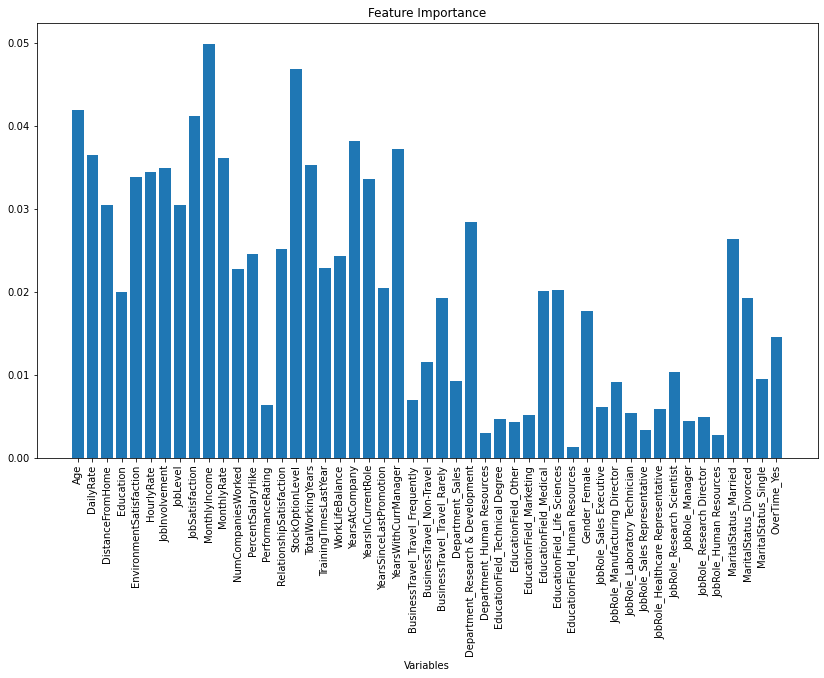

In [30]:
import matplotlib.pyplot as plt
best_model = RF_cv.best_estimator_
best_model.feature_importances_

ind = np.arange(X.shape[1])
plt.bar(ind,best_model.feature_importances_)
plt.xticks(ind,(X.columns),rotation=90)
plt.title('Feature Importance')
plt.xlabel("Variables")
plt.rcParams['figure.figsize'] = [8,12]
plt.show()